In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import os

os.getcwd()


'c:\\Users\\nik\\Desktop\\Berkeley_Projects\\LoadLanguageModel\\bin'

In [220]:
df = pd.read_csv('../data\MFRED_Aggregates_15min_2019Q1-Q4.csv', index_col=0, parse_dates=True).filter(regex=r'^.*kW$')
df = df.iloc[:, 1:]
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df = df.resample('1H').mean()
df = df.stack().reset_index().rename(columns={'level_0': 'timestamp', 'level_1': 'apartment', 0: 'kW'})

# drop the _Kw from the apartment names

df['apartment'] = df['apartment'].str.replace('_kW', '')



In [221]:
# reset index and call the first column apartment
df_meta = pd.read_csv("../data/meta_data.csv", index_col=0).iloc[:-1, :]
df_meta = df_meta.reset_index().rename(columns={'AP ': 'apartment'})
df_meta.columns

Index(['Apt. group', 'Time-averaged real power (σ) [W]',
       'Number of bedrooms (σ)', 'Number of all rooms (σ)',
       'Apt. area (σ) [m2]'],
      dtype='object')

In [222]:


df_meta.rename(columns={'Apt. group': 'apartment'}, inplace=True)
df.set_index('DateTimeUTC', inplace=True)


In [223]:
def timeseries_dataframe_pivot(df):
    df['date'] = df.index.date
    df['time'] = df.index.time

    df_pivot = df.pivot(index='date', columns='time')

    n_days, n_timesteps = df_pivot.shape

    df_pivot.dropna(thresh = n_timesteps // 5, inplace=True)

    df_pivot = df_pivot.fillna(method='ffill', axis = 0)

    df_pivot = df_pivot.droplevel(0, axis=1)

    df_pivot.columns.name = None

    return df_pivot


def data_augmentation(df, n_samples=1000, noise=0.1, scale=0.1, shift_range=(-2,2)):
    df = df.copy()
    df_list = []
    for i in range(n_samples):
        df_noise = df + np.random.normal(0, noise, df.shape)
        shift_value = np.random.uniform(shift_range[0], shift_range[1])
        df_shift = pd.DataFrame(np.roll(df_noise.values, int(shift_value), axis=1), columns=df.columns, index=df.index)
        df_scale = df_shift * (1 + np.random.normal(0, scale, df.shape))
        # set negative values to zero
        df_scale[df_scale < 0] = 0
        # set values above 1 to 1
        df_scale[df_scale > 1] = 1
        df_list.append(df_scale)
    return pd.concat(df_list, axis=0)





In [224]:
# Data augmentation and merging with meta data

list_df_ready = []

for name, group in df[["kW", "apartment"]].groupby('apartment'):
    df_pivot = timeseries_dataframe_pivot(group[["kW"]]).iloc[1:, :]
    df_pivot_augmented = data_augmentation(df_pivot, n_samples=10, noise=0.02, scale=0.02)
    df_meta_data_columns = df_meta.loc[df_meta['apartment'] == name].iloc[:,2:]
    df_pivot_augmented[["bedrooms", "rooms", "area"]] = np.repeat(df_meta_data_columns.values, df_pivot_augmented.shape[0], axis=0)
    list_df_ready.append(df_pivot_augmented)

df_ready = pd.concat(list_df_ready, axis=0)



In [225]:
df_ready

,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,bedrooms,rooms,area
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.193334,0.215687,0.278346,0.279511,0.312269,0.199513,0.313669,0.198162,0.231836,0.245718,...,0.309651,0.140024,0.192597,0.190991,0.172441,0.196247,0.203070,1.2,3.2,62.0
2019-01-03,0.203378,0.272048,0.317941,0.382952,0.391835,0.248254,0.337700,0.209654,0.209059,0.205890,...,0.231725,0.149066,0.234950,0.214482,0.196307,0.201975,0.201447,1.2,3.2,62.0
2019-01-04,0.305454,0.372913,0.336516,0.326296,0.233127,0.303717,0.317113,0.233577,0.247369,0.278356,...,0.311469,0.404650,0.313779,0.319922,0.187513,0.159044,0.205397,1.2,3.2,62.0
2019-01-05,0.258002,0.180603,0.159189,0.182012,0.164361,0.198420,0.159296,0.128929,0.126419,0.142808,...,0.343813,0.241797,0.297004,0.330593,0.200517,0.326535,0.293131,1.2,3.2,62.0
2019-01-06,0.328834,0.324904,0.370525,0.319961,0.277938,0.288576,0.299477,0.330401,0.298682,0.263205,...,0.181116,0.215065,0.215204,0.195727,0.242163,0.163534,0.233539,1.2,3.2,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,0.402118,0.345942,0.355667,0.353624,0.316397,0.316260,0.211588,0.183288,0.162996,0.134391,...,0.196585,0.247929,0.184391,0.215705,0.225999,0.305092,0.401066,2.7,6.5,164.0
2019-12-29,0.323379,0.415011,0.341188,0.289630,0.298095,0.243970,0.267764,0.217980,0.158753,0.108874,...,0.242196,0.215125,0.230510,0.295594,0.347299,0.323028,0.338093,2.7,6.5,164.0
2019-12-30,0.515219,0.309600,0.326386,0.286545,0.290162,0.292530,0.227455,0.177577,0.121846,0.140967,...,0.328925,0.250966,0.352749,0.453777,0.415763,0.450903,0.498180,2.7,6.5,164.0


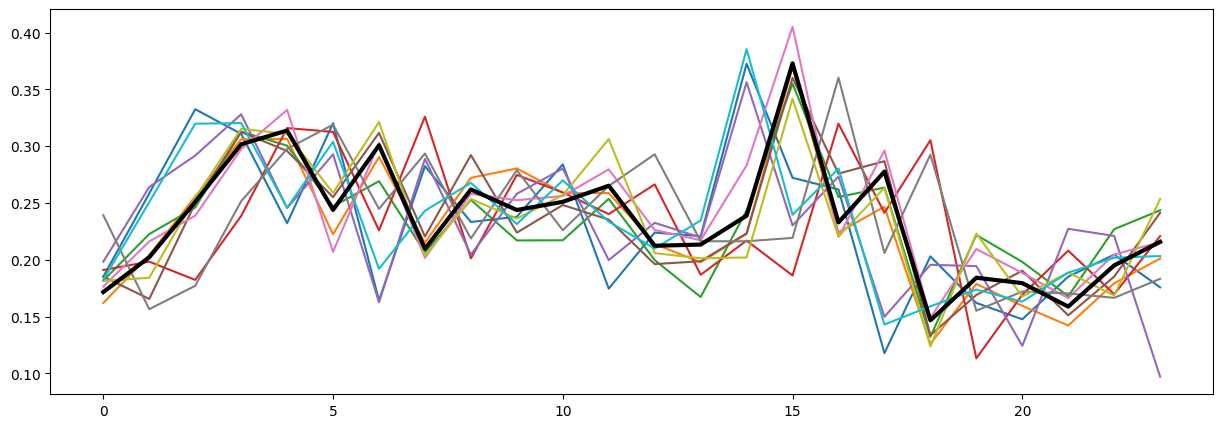

In [194]:
# plot the first 10 augmented samples over the real data

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(10):
    ax.plot(df_augmented.sort_index().iloc[i, :].to_frame().values)
    
ax.plot(df_pivot.iloc[0, :].values, color='black', linewidth=3)